<div style="background-color:#ffe4de; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h1 style="font-size:24px; font-family:calibri; color:#ed2f00;"><b>Codelords - pothole detection and segmentation</b></h1>
    <p style="font-size:20px; font-family:calibri; line-height: 1.5em; text-indent: 20px;"> <strong>Thabo Maibi : </strong> 23141360 </p>
</div>

In [ ]:
!pip install roboflow

In [ ]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
from roboflow import Roboflow
from PIL import Image
from collections import deque
from IPython.display import Video

# Path to the folder containing the CSV files in Google Drive
patch_data_path = '/content/drive/My Drive/Patch_Perfect_Data/'
supplementary_dataset_path = '/content/drive/My Drive/Supplementary_Data/'
pothole_dataset_path = '/content/drive/My Drive/pothole_data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#ffe4de'}, style='darkgrid')

#Loading Pothole detection model from roboflow

In [ ]:
rf = Roboflow(api_key="8eu0AXvuYsVZBGEZHazo")
project = rf.workspace().project("pothole-segmentation-o1kix")
model = project.version("3").model
#testing
#model.infer(image="YOUR_IMAGE.jpg")

loading Roboflow workspace...
loading Roboflow project...


#Provided data exploration

In [ ]:
# Set paths for training and validation image sets
train_patch_image = os.path.join(patch_data_path, 'train_images', 'train_images')
valid_patch_image = os.path.join(patch_data_path, 'test_images', 'test_images')

# Initialize counters for the number of images
num_train_patch_images = 0
num_valid_patch_images = 0

# Initialize sets to hold the unique sizes of images
train_patch_image_sizes = set()
valid_patch_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_patch_image):
    if filename.endswith('.jpg'):
        num_train_patch_images += 1
        image_path = os.path.join(train_patch_image, filename)
        with Image.open(image_path) as img:
            train_patch_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_patch_image):
    if filename.endswith('.jpg'):
        num_valid_patch_images += 1
        image_path = os.path.join(valid_patch_image, filename)
        with Image.open(image_path) as img:
            valid_patch_image_sizes.add(img.size)

# Print the results
print(f"Number of training images from provided dataset: {num_train_patch_images}")
print(f"Number of validation images from provided dataset: {num_valid_patch_images}")

# Check if all images in training set have the same size
if len(train_patch_image_sizes) == 1:
    print(f"All training images have the same size: {train_patch_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_patch_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_patch_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images from provided dataset: 485
Number of validation images from provided dataset: 30
Training images have varying sizes.
Validation images have varying sizes.


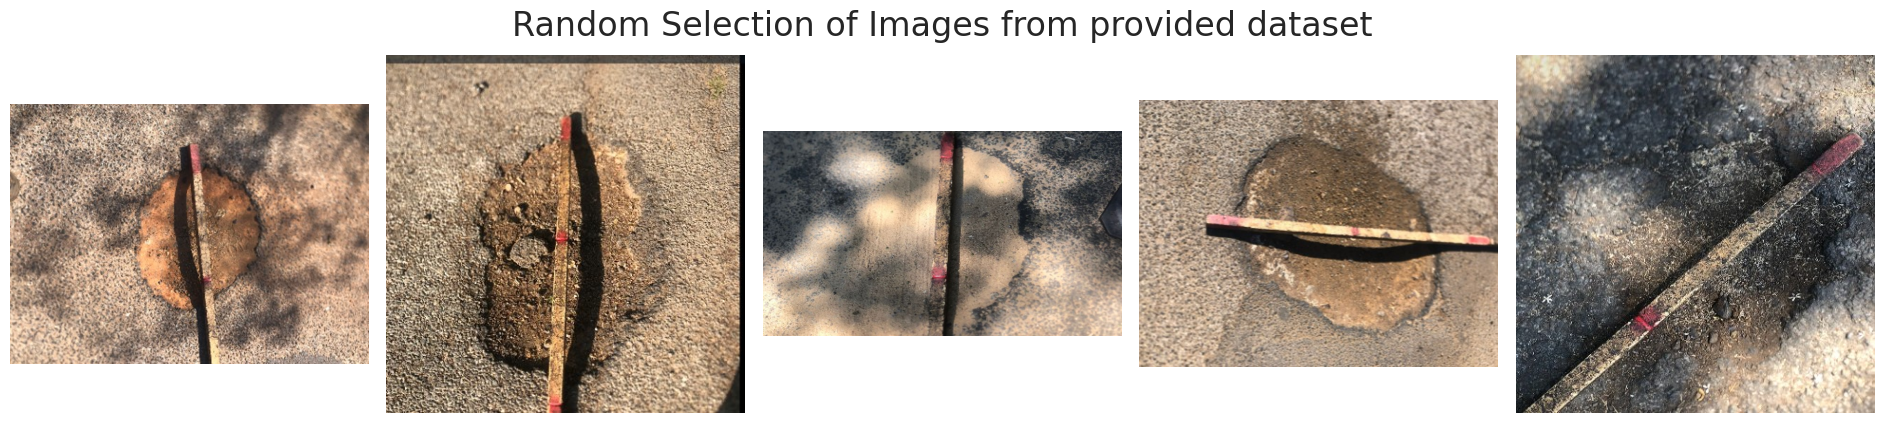

In [ ]:
# Set the seed for the random number generator
random.seed(0)

# Create a list of image files
image_files = [f for f in os.listdir(train_patch_image) if f.endswith('.jpg')]

# Randomly select 15 images
random_images = random.sample(image_files, 5)

# Create a new figure
plt.figure(figsize=(19, 12))

# Loop through each image and display it in a 3x5 grid
for i, image_file in enumerate(random_images):
    image_path = os.path.join(train_patch_image, image_file)
    image = Image.open(image_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

# Add a suptitle
plt.suptitle('Random Selection of Images from provided dataset', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()

# Deleting unnecessary variable to free up memory
del image_files

#Supplementary dataset

In [ ]:
# Set paths for training and validation image sets
train_supplementary_image = os.path.join(supplementary_dataset_path, 'train_images_2', 'potholes_images_jpegs2')

# Initialize counters for the number of images
num_train_supplementary_images = 0

# Initialize sets to hold the unique sizes of images
train_supplementary_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_supplementary_image):
    if filename.endswith('.jpg'):
        num_train_supplementary_images += 1
        image_path = os.path.join(train_supplementary_image, filename)
        with Image.open(image_path) as img:
            train_supplementary_image_sizes.add(img.size)


# Print the results
print(f"Number of training images from supplementary dataset: {num_train_supplementary_images}")

# Check if all images in training set have the same size
if len(train_supplementary_image_sizes) == 1:
    print(f"All supplementary training images have the same size: {train_supplementary_image_sizes.pop()}")
else:
    print("supplementary Training images have varying sizes.")

Number of training images from supplementary dataset: 493
supplementary Training images have varying sizes.


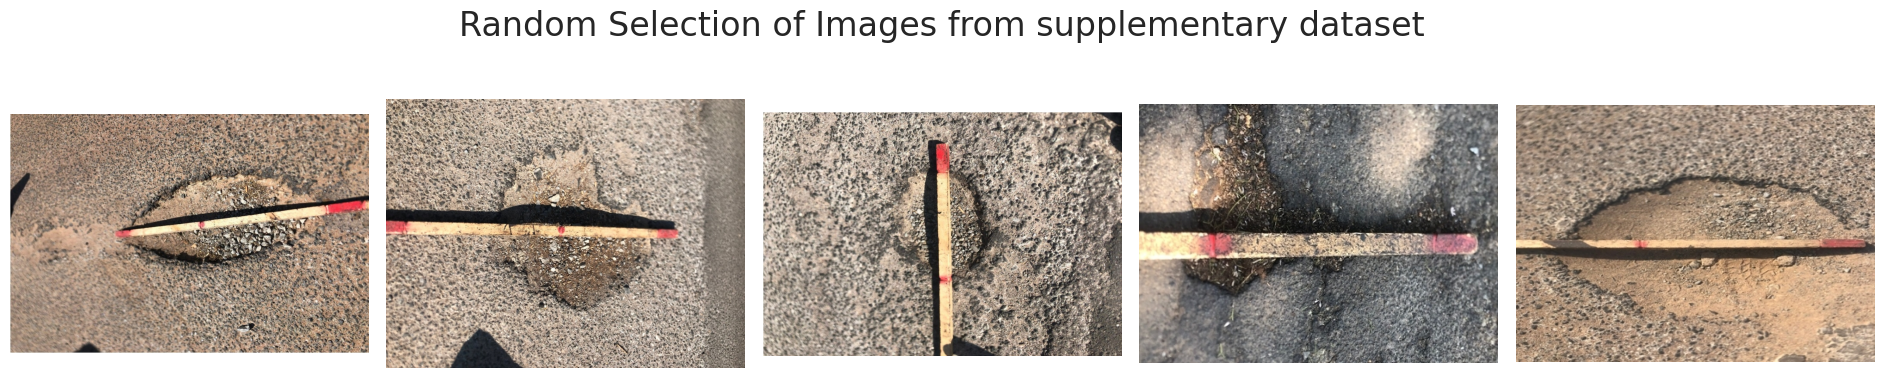

In [ ]:
# Set the seed for the random number generator
random.seed(0)

# Create a list of image files
image_files = [f for f in os.listdir(train_supplementary_image) if f.endswith('.jpg')]

# Randomly select 15 images
random_images = random.sample(image_files, 5)

# Create a new figure
plt.figure(figsize=(19, 12))

# Loop through each image and display it in a 3x5 grid
for i, image_file in enumerate(random_images):
    image_path = os.path.join(train_supplementary_image, image_file)
    image = Image.open(image_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

# Add a suptitle
plt.suptitle('Random Selection of Images from supplementary dataset', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()

# Deleting unnecessary variable to free up memory
del image_files

#Detect and segment potholes in all images

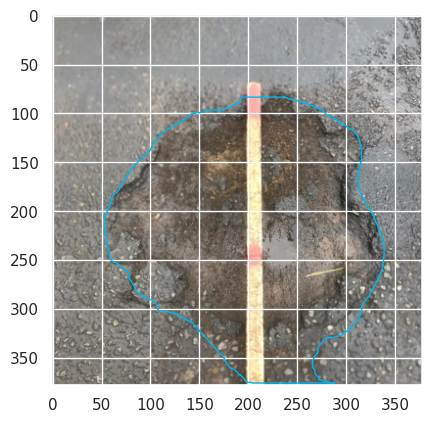

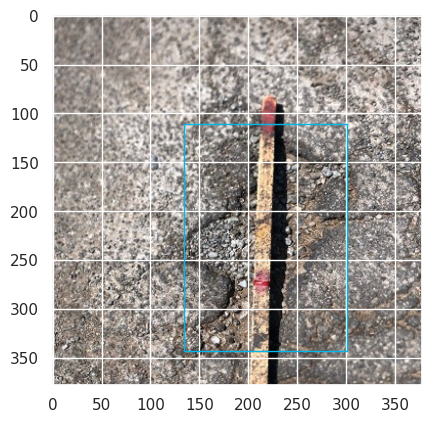

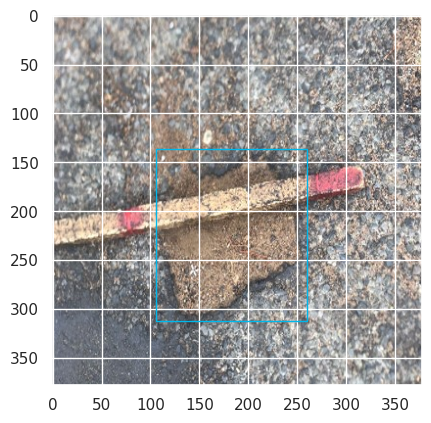

<Figure size 1900x1200 with 0 Axes>

In [ ]:
# Set the seed for the random number generator
random.seed(123)

# Create a list of image files
image_files = [f for f in os.listdir(train_patch_image) if f.endswith('.jpg')]

# Randomly select 5 images
random_images = random.sample(image_files, 3)
# Predict results for each selected image
results = [model.predict(os.path.join(train_patch_image, image_file)) for image_file in random_images]


# Create a figure with subplots
annotated_images = [result[0].plot() for result in results]

annotated_images = [np.array(img) if isinstance(img, Image.Image) else img for img in annotated_images]

# Convert any PIL images to numpy arrays
annotated_images = [
    np.array(img) if isinstance(img, Image.Image) else np.array(img)
    for img in annotated_images
    if img is not None  # Filter out None values
]

# Create a new figure
plt.figure(figsize=(19, 12))

# Loop through each image and display it in a 1x5 grid (since there are 5 images)
for idx, img in enumerate(annotated_images):
    plt.subplot(1, 5, idx + 1)
    if img.dtype in [np.float32, np.float64, np.uint8]:  # Ensure the dtype is correct
        plt.imshow(img)
    else:
        plt.imshow(np.array(img, dtype=np.uint8))  # Convert to uint8 if needed
    plt.axis('off')

# Add a suptitle
plt.suptitle('Testing the pothole detection model', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()


#Testin model perfomance on external dataset

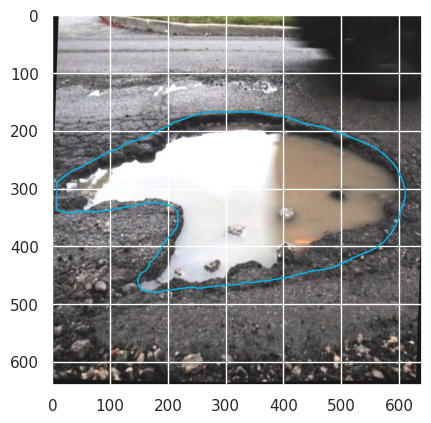

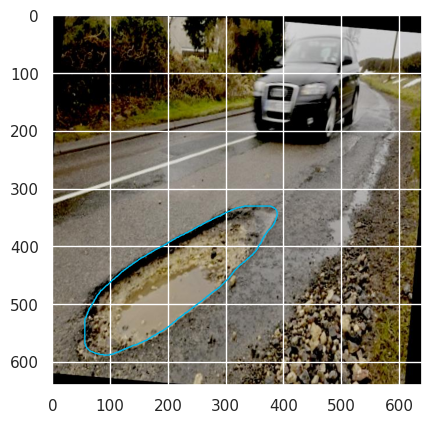

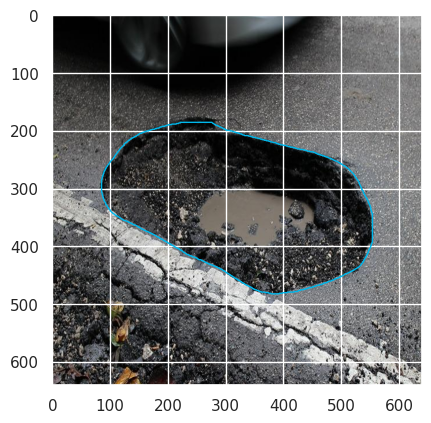

<Figure size 1900x1200 with 0 Axes>

In [ ]:
outsourced_data_image = os.path.join(pothole_dataset_path, 'outsourced')
# Set the seed for the random number generator
random.seed(123)

# Create a list of image files
image_files = [f for f in os.listdir(outsourced_data_image) if f.endswith('.jpg')]

# Randomly select 5 images
random_images = random.sample(image_files, 3)
# Predict results for each selected image
results = [model.predict(os.path.join(outsourced_data_image, image_file),confidence=40) for image_file in random_images]


# Create a figure with subplots
annotated_images = [result[0].plot() for result in results]

annotated_images = [np.array(img) if isinstance(img, Image.Image) else img for img in annotated_images]

# Convert any PIL images to numpy arrays
annotated_images = [
    np.array(img) if isinstance(img, Image.Image) else np.array(img)
    for img in annotated_images
    if img is not None  # Filter out None values
]

# Create a new figure
plt.figure(figsize=(19, 12))

# Loop through each image and display it in a 1x5 grid (since there are 5 images)
for idx, img in enumerate(annotated_images):
    plt.subplot(1, 5, idx + 1)
    if img.dtype in [np.float32, np.float64, np.uint8]:  # Ensure the dtype is correct
        plt.imshow(img)
    else:
        plt.imshow(np.array(img, dtype=np.uint8))  # Convert to uint8 if needed
    plt.axis('off')

# Add a suptitle
plt.suptitle('Testing the pothole detection model', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()


#Creating new dataset of images with potholes segmentation

In [ ]:
def process_and_save_images(model, input_dir, output_dir):
    # Loop through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust for other image formats if necessary
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            # Process the image using the model (replace model.predict with the actual method if different)
            result = model.predict(input_path)

            for prediction in result:
                # Load the image
                image = cv2.imread(input_path)

                # Extract and prepare points
                points = prediction["points"]
                np_points = np.array([(p["x"], p["y"]) for p in points], np.int32)
                np_points = np_points.reshape((-1, 1, 2))  # Reshape for polylines

                # Draw the boundary with a green line
                cv2.polylines(image, [np_points], isClosed=True, color=(0, 255, 0), thickness=2)

                # Save the processed image to the output directory
                cv2.imwrite(output_path, image)

**1. For provided data**

In [ ]:
#define output directories
output_dir_test = os.path.join(pothole_dataset_path, 'test')
output_dir_train = os.path.join(pothole_dataset_path, 'train')



In [ ]:
#process and save new images
# process_and_save_images(model, valid_patch_image, output_dir_test)
# process_and_save_images(model, train_patch_image, output_dir_train)

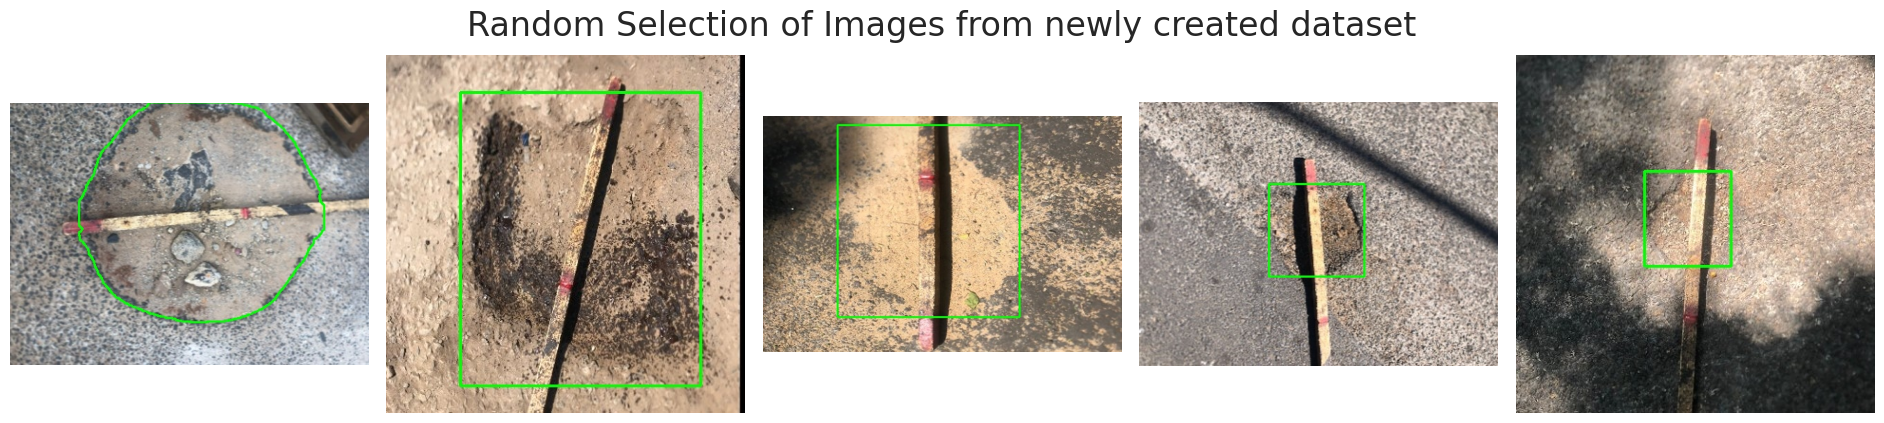

In [ ]:
# Set the seed for the random number generator
random.seed(0)

# Create a list of image files
image_files = [f for f in os.listdir(output_dir_train) if f.endswith('.jpg')]

# Randomly select 15 images
random_images = random.sample(image_files, 5)

# Create a new figure
plt.figure(figsize=(19, 12))

# Loop through each image and display it in a 3x5 grid
for i, image_file in enumerate(random_images):
    image_path = os.path.join(output_dir_train, image_file)
    image = Image.open(image_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

# Add a suptitle
plt.suptitle('Random Selection of Images from newly created dataset', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()

# Deleting unnecessary variable to free up memory
del image_files

**2. For supplementary data**

In [ ]:
#define output directories
output_dir_supplementary_train = os.path.join(pothole_dataset_path, 'supplementary')



In [ ]:
#process and save new images
# process_and_save_images(model, train_supplementary_image, output_dir_supplementary_train)

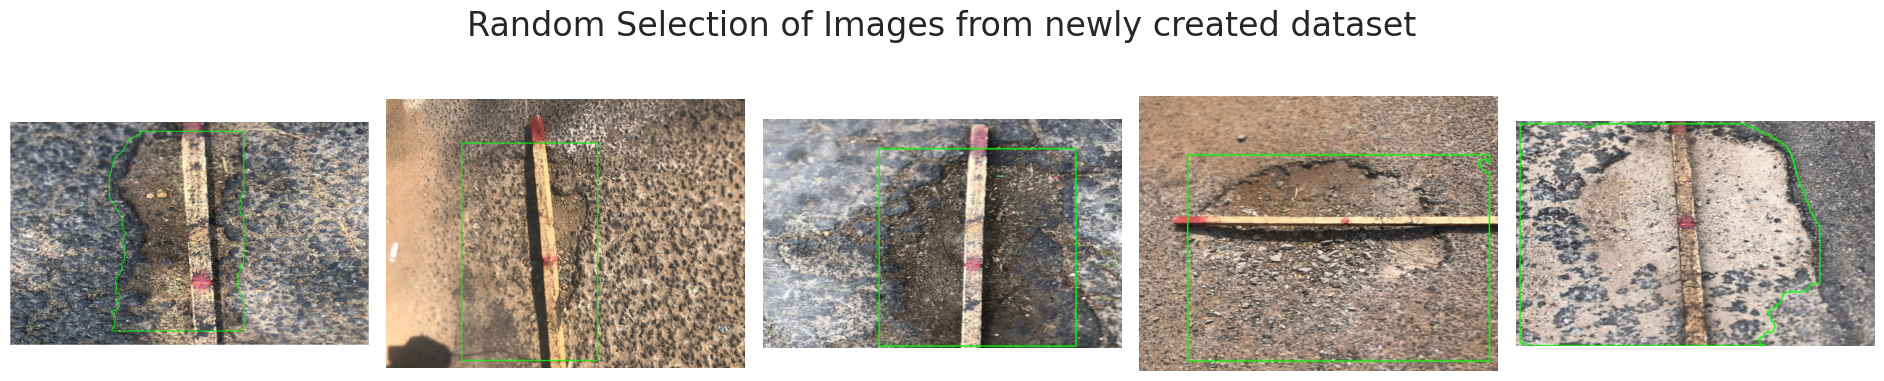

In [ ]:
# Set the seed for the random number generator
random.seed(5)

# Create a list of image files
image_files = [f for f in os.listdir(output_dir_supplementary_train) if f.endswith('.jpg')]

# Randomly select 15 images
random_images = random.sample(image_files, 5)

# Create a new figure
plt.figure(figsize=(19, 12))

# Loop through each image and display it in a 3x5 grid
for i, image_file in enumerate(random_images):
    image_path = os.path.join(output_dir_supplementary_train, image_file)
    image = Image.open(image_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

# Add a suptitle
plt.suptitle('Random Selection of Images from newly created dataset', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()

# Deleting unnecessary variable to free up memory
del image_files